---
# INFO-H600 - Computing Foundations of Data Sciences

## Team 14 : 

Roman Lešický, Theo Abraham, Kevin Straatman, Lara Hansen, Grégoire Van den Eynde and Nicolas Roux

Version of python : 3.11.14 | packaged by conda-forge 

---

# Library:

###### The download environment.txt is present within the Github repository of the project https://github.com/RomanLesicky/Data_Science_Project_INFO_H600

### How path's are handled in this project:

In [3]:
from pathlib import Path # We are using the pathlib library for our paths 

# The way the code works is that we first locate the project's root
project_root = Path.cwd().resolve()

# Then we make a variable which hall be used as our data directory path which is sued for everyone in this project 
# For steps 2 till 5 included.

data_dir = project_root / "data" 

# Simple print for as a sanity check
print("Project root:", project_root)
print("Data dir:", data_dir)

Project root: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600
Data dir: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data


### Rest of the library:

In [ ]:
from pyspark.sql import SparkSession, functions
from pyspark.sql.functions import mean, round

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#! To be continued ofc 

---

# Overview of the project :

# `WIP`

---

# Task 1:

`TBD`

# DO NOT FORGET TO DO THE DOCUMENTATION in the `PDF`

### 1.0 Set-up of the SparkSession

In [5]:
# Int this cell we initialise a SparkSession, which can be reused.
# An important part of this code is that indicating to Spark to run all available CPU cores, for each task utilizing Spark.
# Therefore, the use of the code has been warned that when they are running cell which are Spark related this will utilize their whole CPU.
# The reason for doing this is that it gives us parallelism without needing a proper cluster
# Additionally, for larger file size we are allocating 16gb for the heap for the driver and executors (JVM), 200 of shuffles is reasonable and works for larger files 

spark = (SparkSession.builder.appName("MillionPlaylistProject").master("local[*]").config("spark.driver.memory", "16g")      
    .config("spark.executor.memory", "16g").config("spark.driver.maxResultSize", "4g").config("spark.sql.shuffle.partitions", "200").getOrCreate())

spark  # Just for postery we display the session 

### 1.1 Reading JSON slices into raw DataFrames using Spark

In [4]:
"""
This is an important part of the project which needs to be addressed. 

The question "How many slice files / slices do we want to read?" needs to be asked since this determined the trade-off between scalability and practical runtime.
Essentially, the answer to that question is having a sufficient amount of data that our metrics will be good whilst not calculating until forever. 

As a group we have decide to hardcode the value 5 for demonstration purposes, this means that we shall ony use mpd.slice.0 to 4999 so only about 5k playlists. 
The sole reason for this specific value is that it small enough to run very fast and yet demonstrate that the pipeline works. 
Additionally the use can adapt this number via the global variable `NUMBER_OF_SLICES`, but they shall keep in mind the that they are using all the cores of their CPU for this. 

That being said, for practical reasons which concern task's 3 and 4 (5 too) we shall use a dataset that contains 50 slices meaning 50 thousand playlists. 
This value does provides enough data to obtain stable aggregate statistics and similarity scores while keeping computation times manageable on a single machine.

Here we do not use a randomized method to chose the slices, since the data at hand is not ordered nor are we worried with a certain bias since we shall be using the 50k 
version for the actual metric determination. 

For context:

Running the 5k version uses only a couple of gb of ram, whilst using the 50k slice size takes about 14 gb of ram.

"""

# So this global variable is to be changed if one desires for a higher number of slices 
# This is very IMPORTANT this number must not be above 1000, since the database provides only a 1000 slices and could cause an Indexing error.
# If the user choses to put 1000 this represents the entire 32.1 Gb of data which is the full database.
NUMBER_OF_SLICES = 5

# This is the file path to the original Million Playlist Dataset to be used only in this Task, for the rest of the project the data_dir variable is meant to be used.
# This dataset will never be published to github since it's under the .gitignore file. 
data_dir_MGD_Original_Data = project_root / "data_Million_Playlist_Dataset" 

# Function to allow for numeric sorting and not str-related sorting, essentially this function will be used as the key parameter when using the sorted function

def slice_start_key_numeric(path: Path) -> int:
    """
    So, this function allows to extract the numeric "starting" index from filenames. 
    This allows to sort slices in the correct numeric order.
    """
    name = path.name # As an example, for mpd.slice.1000-1999.json
    
    # Here we will split to get the middle and starting string 
    the_numeric_value = name.split(".")[2] # this will split in function of "." so we get a list of ["mpd", "slice", "1000-1999", "json"] here we want 1000-1999 so [2]
    starting_string = the_numeric_value.split("-")[0] # here we split again and we also get a list but we only want the starting string so [0]
    
    # And we return the string into an integer to ger a proper numeric sorting 
    return int(starting_string) 

# Here we load all the "mpd.slice.*.json" type files which we sort in function of their numeric values  
# This creates a list of ordered Path object from all the MDP slice's.
all_slices_of_the_playlists = sorted(data_dir_MGD_Original_Data.glob("mpd.slice.*.json"),key=slice_start_key_numeric) # Here we do use the helper function slice_start_key_numeric as detailed above 

# We build a list of inputs paths for Spark, which we also use for printing the MPD files as a precaution 
input_paths = [str(path) for path in all_slices_of_the_playlists[:NUMBER_OF_SLICES]]

# The printing 
print(f"\nThe number of slices which was inputted by the user = {NUMBER_OF_SLICES}:")
for paths in input_paths:
    print("  ", paths)

# So, here we do start the actual PySpark pipeline where we read the selected slice files as a single Spark DataFrame.
# In here each of the files has the structure: {"info": {...}, "playlists": [ {...}, {...}, ... ]}
playlists_unedited_DataFrame = (spark.read.option("multiLine", True).json(input_paths))

# This means that we can directly parse nested multi-line JSON into a structured DataFrame, so we don’t need to write manual parsing code which would need to be done with Dask.


The number of slices which was inputted by the user = 5:
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.0-999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.1000-1999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.2000-2999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.3000-3999.json
   C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_Million_Playlist_Dataset\mpd.slice.4000-4999.json


### 1.2 Flattening pipeline 

# Add more infos here cuz this is a bit meager 

> Note: Since our pipeline doesn't run on the entire 32.1 GB but rather on a sub-sample of a couple of slices (50 max) we rely on Spark's built-in schema inference. If we processed all 35 GB or ran on a cluster, we would define an explicit StructType schema to avoid an extra pass over the data.

In [5]:
"""
This second step of Task 1 consists in a flattening pipeline: we take the slice-level JSON files, extract all playlists, 
and then transform them into a final table with one row per (playlist, track).

From the 1.1 point we ended up with `playlists_unedited_DataFrame` which is a single dataframe "shape" according to how many `NUMBER_OF_SLICES`
the user has chosen. The data that is stored here corresponds to one row per JSON slice file.

Where each row has:
- an `info` struct, and

- a `playlists` array, where each element is a playlist with its own fields (pid, name, num_tracks, tracks, ...) 

For the remainder of the Tasks in this project it is much more convenient to work with "flat" tables rather 
than nested arrays and structs. Therefore we shall be making two table:

1) The first one named playlist-level table, which contains: 

   - one row per playlist
   - 9 columns: pid, name,collaborative,modified_atm,num_tracks, num_albums, num_followers, duration_ms and tracks 
   - This last `tracks` column still stores, for each playlist, the full array of its track entries. We will use it in the next step 
     to create one row per (playlist, track), and it also lets us easily reconstruct the original order of tracks if needed.


2) And a second one, named playlist-track table, which consists of:

   - one row per (playlist, track)
   - 15 columns: same information as the previous one, but we do not have tracks but tracks_pos, track_uri, track_name, artist_uri, artist_name,
                 album_uri, album_name, track_duration_ms

Essentially, the objective of these 2 tables is that we have a "normalized" outlook on the original data that we downloaded. Where:

- `playlists_flat_DataFrame` is a "playlist type" table which mainly contains information about the Playlist themselves 
                             from which specific Playlist metrics can be derived 
                             
- `playlist_track_DataFrame` in the same spirit but for tracks related information 

This helps us to:
- compute aggregate statistics in Task 2, 
- building track similarity from co-occurrences in playlists (Task 3),
- building playlist similarity (Task 4),
- and make a playlist continuation model (Task 5)

As briefly discussed in the markdown cell for section 1.2, we rely on Spark's built-in schema inference for the JSON input. The library inspects the JSON 
files and automatically infers field names and data types (string, long, array, struct, ...). We opted for this approach rather than defining an explicit 
JSON schema because we are not processing the full 32.1 GB of data, and therefore we do not strictly need very fine-grained control over every data type.

We are aware that if this this project needed all the data then a JSON scheme like `StructType` would have been necessary. Which would avoids an
extra pass of schema inference, making the job more robust against slight variations in the input.

In our particular setting, the inferred schema is stable across slices (even for a 50k-playlist subset), so we accept this trade-off between convenience and strictness.
"""

# Firstly we build the `playlists_flat_DataFrame` table: we explode the `playlists` array so that each playlist in each slice becomes its own row,
# and then we select only the playlist-level fields we need (pid, name, counts, duration, tracks).

playlists_DataFrame = playlists_unedited_DataFrame.select(
    functions.explode("playlists").alias("playlist"))

# From each `playlist` struct, we will only select the "playlist" related fields and `tracks` too.

playlists_flat_DataFrame = playlists_DataFrame.select(
    functions.col("playlist.pid").alias("pid"),                 # unique playlist id
    functions.col("playlist.name").alias("name"),               # playlist name
    functions.col("playlist.collaborative").alias("collaborative"),
    functions.col("playlist.modified_at").alias("modified_at"), # last modification timestamp
    functions.col("playlist.num_tracks").alias("num_tracks"),   # number of tracks in the playlist
    functions.col("playlist.num_albums").alias("num_albums"),   # number of distinct albums
    functions.col("playlist.num_followers").alias("num_followers"),
    functions.col("playlist.duration_ms").alias("duration_ms"), # total duration of the playlist
    functions.col("playlist.tracks").alias("tracks")            # still an array of track structs
)

# Secondly, we build the `playlist_track_DataFrame` table in a similar spirit: we explode the `tracks` array inside each playlist 
# and then flatten the nested `track` struct into explicit columns so that each row corresponds to a single (playlist, track) pair with all its metadata.

playlist_track_DataFrame = playlists_flat_DataFrame.select(
    functions.col("pid"),
    functions.col("name").alias("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("duration_ms").alias("playlist_duration_ms"),
    functions.explode("tracks").alias("track")   # so here we explode the tracks array to make one row per track
)

# Here the `track` column is still a struct (pos, track_uri, track_name, artist, album, ...), so it needs to be flattened into individual columns, 
# so that each row is a fully explicit (playlist, track) record with all relevant information.

playlist_track_DataFrame = playlist_track_DataFrame.select(
    functions.col("pid"),
    functions.col("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("playlist_duration_ms"),

    functions.col("track.pos").alias("track_pos"),             # position of the track in the playlist
    functions.col("track.track_uri").alias("track_uri"),       # Spotify track URI
    functions.col("track.track_name").alias("track_name"),     # track title
    functions.col("track.artist_uri").alias("artist_uri"),     # Spotify artist URI
    functions.col("track.artist_name").alias("artist_name"),   # artist name
    functions.col("track.album_uri").alias("album_uri"),       # Spotify album URI
    functions.col("track.album_name").alias("album_name"),     # album name
    functions.col("track.duration_ms").alias("track_duration_ms")  # duration of the specific track
)


#### 1.2.1 Scheme of  `playlist-level table` and `playlist–track table`:


In [6]:
print("Schema of playlist-level table:" + "\n")
playlists_flat_DataFrame.printSchema()

print("\nExample of 5 playlists:")
playlists_flat_DataFrame.show(5, truncate=False)

Schema of playlist-level table:

root
 |-- pid: long (nullable = true)
 |-- name: string (nullable = true)
 |-- collaborative: string (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- tracks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album_name: string (nullable = true)
 |    |    |-- album_uri: string (nullable = true)
 |    |    |-- artist_name: string (nullable = true)
 |    |    |-- artist_uri: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- pos: long (nullable = true)
 |    |    |-- track_name: string (nullable = true)
 |    |    |-- track_uri: string (nullable = true)


Example of 5 playlists:
+----+--------+-------------+-----------+----------+----------+-------------+-----------+--------------------------------------

In [7]:
print("\nSchema of playlist-track table:" + "\n")
playlist_track_DataFrame.printSchema()

print("\nExample of 5 playlist-track rows:")
playlist_track_DataFrame.show(5, truncate=False)


Schema of playlist-track table:

root
 |-- pid: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- playlist_duration_ms: long (nullable = true)
 |-- track_pos: long (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_duration_ms: long (nullable = true)


Example of 5 playlist-track rows:
+----+-------------+----------+----------+-------------+-----------+--------------------+---------+------------------------------------+----------------------------+-------------------------------------+----------------------------+------------------------------------+---------------------------

### 1.3 Saving flattened DataFrames locally 

`To not run if one doesn't want to locally save the dataframes`

Additionally, to make this cell of code work the user needs to have winutils.exe and hadoop.dll installed locally. This can be found on this github page: 

- https://github.com/cdarlint/winutils

The version which was used for this project was hadoop-3.3.6.

In [6]:
"""
This third sub-part of Task 1 is about saving the flattened DataFrames for later Tasks so that we do not have to 
re-do the whole Step 1 pipeline more than once. This pipeline is very swift for the 5k example but it gets more and more 
heavy when increasing `NUMBER_OF_SLICES`.
"""

# NUMBER_OF_SLICES is defined in Section 1.1

# Here we have a very simple if/else code to decide on the folder's name based on NUMBER_OF_SLICES
if NUMBER_OF_SLICES >= 1000:  # if the user inputted 1000 then that corresponds to the full playlist dataset
    folder_name = "Full_Playlist"
else:  # otherwise we add that specific number as part of the folder name
    folder_name = f"{NUMBER_OF_SLICES}k_Playlists"

# Here we define the correct path
post_task1_dir = project_root / "data_post_Task_1" / folder_name

# Here we use mkdir to make it
post_task1_dir.mkdir(parents=True, exist_ok=True)

# Here is where we save the DataFrames produced in sections 1.1 and 1.2.
# For the playlist-level table, we drop the `tracks` array column to keep only playlist metadata.
# This needs to be done to safely save larger files such as 50k otherwise the code keeps crashing, crucially dropping the task 
# isn't the worst idea since in the playlist related table we do not need these information since they are all track related. 
# And finally all track-level information is already stored explicitly in `playlist_track_DataFrame`, which we also save.

playlists_flat_out = post_task1_dir / "playlists_flat"
playlist_track_out = post_task1_dir / "playlist_track"

# Drop the heavy `tracks` array before writing to avoid OutOfMemory errors for larger NUMBER_OF_SLICES
playlists_flat_to_save = playlists_flat_DataFrame.drop("tracks")

playlists_flat_to_save.write.mode("overwrite").parquet(str(playlists_flat_out))
playlist_track_DataFrame.write.mode("overwrite").parquet(str(playlist_track_out))
# We are in overwrite mode so each time this code cell is run it overwrites what is already present,
# so the user should be cautious.

# Just to make things very clear 
print("\nSaved playlist tables to:")
print(playlists_flat_out)
print(playlist_track_out)



Saved playlist tables to:
C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\5k_Playlists\playlists_flat
C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\5k_Playlists\playlist_track


----

# Task 2:

# Do the whole pipeline for 5k and 50k to see if there are any differences !!!

### 2.0 Loading a spark session:

Since the `Spark` session from Step 1 is to loaded only for that specific step we need to redefine the spark session here:

In [ ]:
spark = (SparkSession.builder.appName("MillionPlaylistProject_Tasks2to5").master("local[*]").getOrCreate())

# Again we are using all cores of the CPU but are not allocating as much memory so this should be relatively safe to run resource-wise.

### 2.1 Loading processed data from Task 1:

#### `5k_Playlists`

In [6]:
# data_dir is defined in the Library (top section) of this Notebook  

processed_dir = data_dir / "5k_Playlists"

# Defining the paths to the two tables that we will be using 
playlists_flat_path = processed_dir / "playlists_flat"
playlist_track_path = processed_dir / "playlist_track"  

# Just for posterity to print that where everything is 
print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

# Loading DataFrames that were created using spark.read (which is the reason why we need the SparkSession) 
playlists_flat_DataFrame = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame = spark.read.parquet(str(playlist_track_path))

playlists_flat_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data\5k_Playlists\playlists_flat
playlist_track_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data\5k_Playlists\playlist_track


#### `50k_Playlists`

In [7]:
# The precise path where the 50k data is stored is within the data_post_Task_1 folder.
# Here we are using project_root which is also is defined in the Library (top section) of this Notebook  

data_dir_for_50k = project_root / "data_post_Task_1" / "50k_Playlists"

# Same principal as the cell above 
playlists_flat_path = data_dir_for_50k / "playlists_flat"
playlist_track_path = data_dir_for_50k / "playlist_track"  

print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

playlists_flat_DataFrame_50k = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame_50k = spark.read.parquet(str(playlist_track_path))

playlists_flat_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlists_flat
playlist_track_path: C:\Users\roman\Desktop\Master - ULB\2nd year\Q1\Intro Data Sc\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlist_track


### 2.2 Basic statistical exploration:

​-> add Sparsity add here ???

#### `5k_Playlists`

#### `50k_Playlists`

#### Track statistics:

In [30]:

# Here we shall calculate the various statistics using functions from spark
number_of_playlists = playlists_flat_DataFrame_50k.count()
total_number_of_rows      = playlist_track_DataFrame_50k.count()
number_of_unique_tracks    = playlist_track_DataFrame_50k.select("track_uri").distinct().count()
number_of_unique_artists   = playlist_track_DataFrame_50k.select("artist_uri").distinct().count()
number_of_unique_albums    = playlist_track_DataFrame_50k.select("album_uri").distinct().count()

average_number_of_followers = playlists_flat_DataFrame_50k.select(mean("num_followers")).first()[0]
average_number_of_tracks    = playlists_flat_DataFrame_50k.select(mean("num_tracks")).first()[0]

average_duration_in_mins  = playlist_track_DataFrame_50k.select(round(mean("track_duration_ms"))).first()[0] / 60000

# Pandas dataframe to present the basic statistics 
Summary_DataFrame_Tracks = pd.DataFrame({
    "Metric": ["Number of Playlists","Total Rows","Unique Tracks","Unique Artists","Unique Albums","Average nmb follower per playlist","Average tracks per playlist","Average track duration (mins)"],
    "Value": [number_of_playlists, total_number_of_rows, number_of_unique_tracks, number_of_unique_artists,number_of_unique_albums,average_number_of_followers, average_number_of_tracks,average_duration_in_mins]
    })

Summary_DataFrame_Tracks

,Metric,Value
0,Number of Playlists,5.000000e+04
1,Total Rows,3.344374e+06
2,Unique Tracks,4.618800e+05
3,Unique Artists,8.048300e+04
4,Unique Albums,1.956000e+05
5,Average nmb follower per playlist,2.623580e+00
6,Average tracks per playlist,6.688748e+01
7,Average track duration (mins),3.910800e+00


#### Playlist statistics:

In [ ]:
# Same principal as above 
number_of_playlists = playlists_flat_DataFrame_50k.count()
number_of_unique_names = playlists_flat_DataFrame_50k.select("name").distinct().count()

average_albums_per_playlist = playlists_flat_DataFrame_50k.select(mean("num_albums")).first()[0]

# This is in hours since the value would be too big in minutes !!!
raw_duration_hours = playlists_flat_DataFrame_50k.select(mean("duration_ms")).first()[0] / 3600000
average_playlist_duration_hours = np.round(raw_duration_hours, 4) # For this one the round didn't want to work directly so need to do it in two times 

Summary_DataFrame_Playlists = pd.DataFrame({
    "Metric": ["Number of Playlists", "Unique Playlist Names", "Average albums per playlist", "Average playlist duration (hours)"],
    "Value": [number_of_playlists, number_of_unique_names, average_albums_per_playlist, average_playlist_duration_hours]
})

Summary_DataFrame_Playlists

,Metric,Value
0,Number of Playlists,50000.00000
1,Unique Playlist Names,19156.00000
2,Average albums per playlist,49.92954
3,Average playlist duration (hours),4.35970


### 2.3 General visualization of variables:

In this section you can plot:

Top 10 artists by: number of playlists they appear in /  (optionally) number of total track occurrences

Top 10 tracks by: number of playlists they appear in

Histogram of num_tracks per playlist (50k): shows typical playlist lengths.

Histogram of playlist total duration (in minutes). Year distribution (modified_at) (as you said):

bar plot: number of playlists per year from 2010–2017.

Optionally:

histogram of number of playlists per track (to visualise the long-tail).

#### `5k_Playlists`


#### `50k_Playlists`


#### Track statistics:



C:\Users\roman\AppData\Local\Temp\ipykernel_51720\2135306348.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_artists_df, x="count", y="artist_name", ax=ax[0], palette="viridis")
C:\Users\roman\AppData\Local\Temp\ipykernel_51720\2135306348.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tracks_df, x="count", y="label", ax=ax[1], palette="magma")


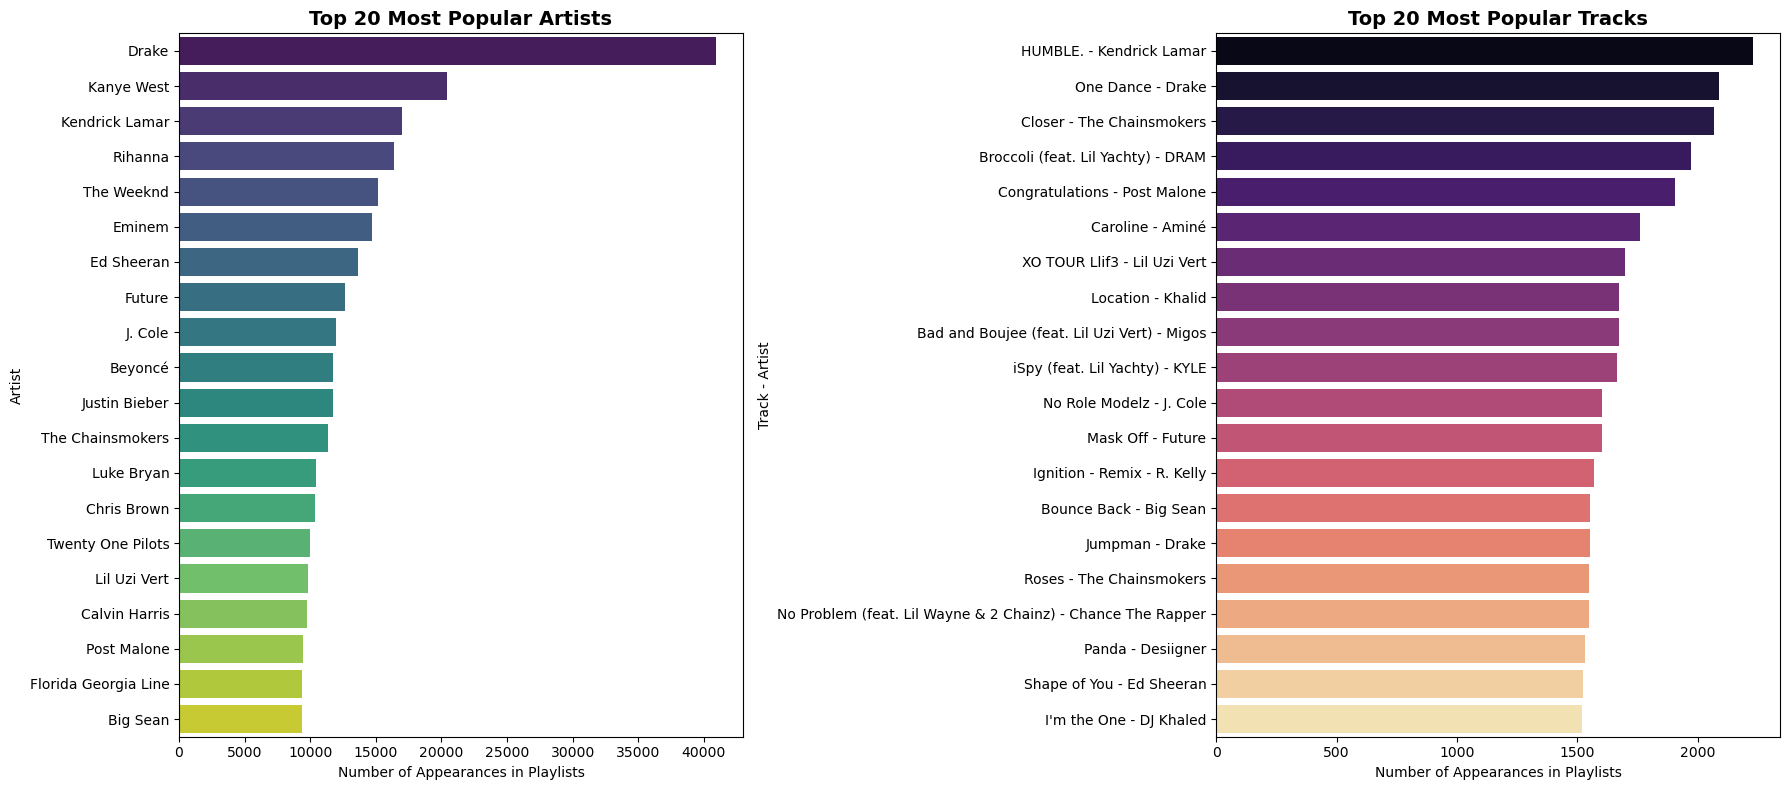

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions

# --- Step 1: Prepare the Data (Spark Side) ---

# A. Top Artists
# We count how many times each artist appears across all playlists
top_artists_df = playlist_track_DataFrame_50k.groupBy("artist_name") \
    .count() \
    .orderBy(functions.col("count").desc()) \
    .limit(20) \
    .toPandas()

# B. Top Tracks
# We group by both track AND artist to avoid confusion (e.g., "Hello" by Adele vs. Lionel Richie)
top_tracks_df = playlist_track_DataFrame_50k.groupBy("track_name", "artist_name") \
    .count() \
    .orderBy(functions.col("count").desc()) \
    .limit(20) \
    .toPandas()

# Create a readable label like "Humble. - Kendrick Lamar"
top_tracks_df["label"] = top_tracks_df["track_name"] + " - " + top_tracks_df["artist_name"]

# --- Step 2: Visualization (Matplotlib/Seaborn Side) ---

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Top Artists
sns.barplot(data=top_artists_df, x="count", y="artist_name", ax=ax[0], palette="viridis")
ax[0].set_title("Top 20 Most Popular Artists", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Number of Appearances in Playlists")
ax[0].set_ylabel("Artist")

# Plot 2: Top Tracks
sns.barplot(data=top_tracks_df, x="count", y="label", ax=ax[1], palette="magma")
ax[1].set_title("Top 20 Most Popular Tracks", fontsize=14, fontweight='bold')
ax[1].set_xlabel("Number of Appearances in Playlists")
ax[1].set_ylabel("Track - Artist")

plt.tight_layout()
plt.show()

#### Playlist statistics:


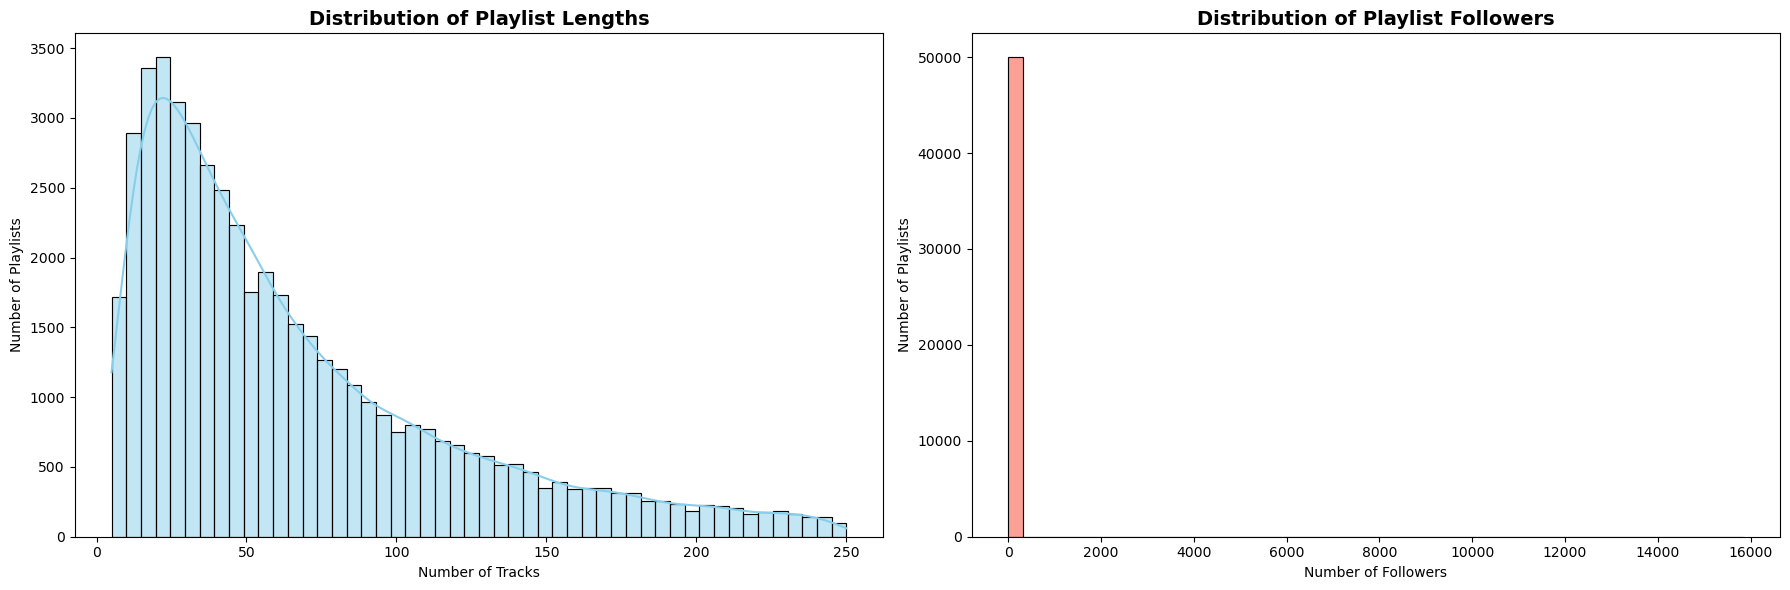

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions

# --- Step 1: Prepare the Data (Spark Side) ---
# We select only the columns we need.
# Since we have 50k rows (one per playlist), we can collect all of them to Pandas safely.
playlist_stats_df = playlists_flat_DataFrame_50k.select("num_tracks", "num_followers").toPandas()

# --- Step 2: Visualization (Matplotlib/Seaborn Side) ---

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Distribution of Playlist Length (num_tracks)
# We use a histogram with a Kernel Density Estimate (KDE) to see the shape.
sns.histplot(data=playlist_stats_df, x="num_tracks", bins=50, kde=True, color="skyblue", ax=ax[0])
ax[0].set_title("Distribution of Playlist Lengths", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Number of Tracks")
ax[0].set_ylabel("Number of Playlists")

# Plot 2: Distribution of Followers (num_followers)
# Note: This is usually extremely skewed (Power Law). Most have 1 follower; a few have 10k.
# To make it readable, we often use a log scale, but here is the raw distribution first.
sns.histplot(data=playlist_stats_df, x="num_followers", bins=50, kde=False, color="salmon", ax=ax[1])
ax[1].set_title("Distribution of Playlist Followers", fontsize=14, fontweight='bold')
ax[1].set_xlabel("Number of Followers")
ax[1].set_ylabel("Number of Playlists")
# Optional: Set y-scale to log if the bar at '1' is too huge to see anything else
# ax[1].set_yscale('log') 

plt.tight_layout()
plt.show()

#### Year distribution by year: 

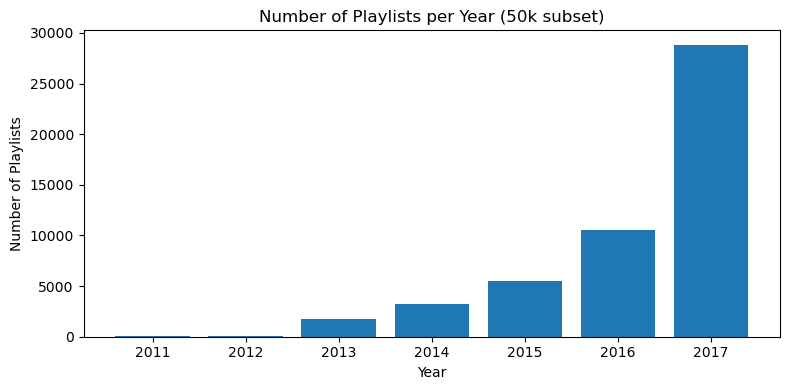

In [48]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

playlists_year_df = (
    playlists_flat_DataFrame_50k
    .withColumn("year", F.year(F.from_unixtime("modified_at")))
    .groupBy("year")
    .agg(F.count("*").alias("num_playlists"))
    .orderBy("year")
    .toPandas()
)

plt.figure(figsize=(8, 4))
plt.bar(playlists_year_df["year"], playlists_year_df["num_playlists"])
plt.title("Number of Playlists per Year (50k subset)")
plt.xlabel("Year")
plt.ylabel("Number of Playlists")
plt.tight_layout()
plt.show()


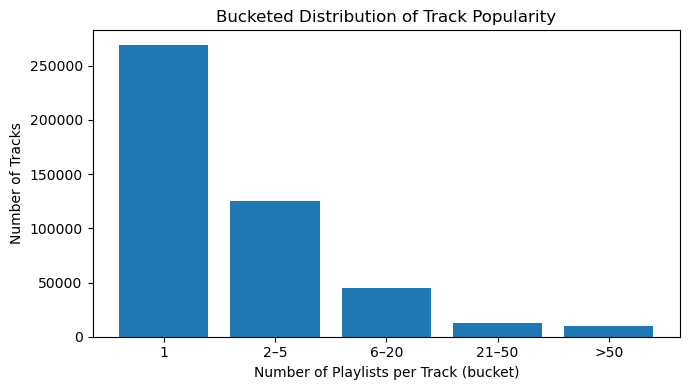

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Spark → Pandas: number of playlists per track
track_popularity = (
    playlist_track_DataFrame_50k
    .groupBy("track_uri")
    .agg(F.countDistinct("pid").alias("num_playlists"))
    .toPandas()
)

# Define buckets: 1, 2–5, 6–20, 21–50, >50 (adjust if you want)
bins = [1, 2, 6, 21, 51, track_popularity["num_playlists"].max() + 1]
labels = ["1", "2–5", "6–20", "21–50", ">50"]

track_popularity["pop_bucket"] = pd.cut(
    track_popularity["num_playlists"],
    bins=bins,
    right=False,
    labels=labels
)

bucket_counts = (
    track_popularity["pop_bucket"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(7, 4))
plt.bar(bucket_counts.index.astype(str), bucket_counts.values)
plt.title("Bucketed Distribution of Track Popularity")
plt.xlabel("Number of Playlists per Track (bucket)")
plt.ylabel("Number of Tracks")
plt.tight_layout()
plt.show()


# Here I have too much things but so I will cut some out of these 

### 2.4 Statistical and Graphical inference unto the Tracks DataFrame: 

In this section, we focus on *track-centric* statistics computed from the
`playlist_track_DataFrame` (5k subset) and `playlist_track_DataFrame_50k`
(50k subset). These statistics will directly inform our design choices for:

- **Task 3**: definition of a similarity score between tracks based on their
  co-occurrence in playlists.
- **Task 5**: playlist continuation, where we need to select *new* tracks that
  are compatible with the existing ones in a playlist.

#### 2.4.1 Track popularity and long-tail behaviour

We define the **popularity** of a track as the number of distinct playlists in
which it appears. Concretely, we group the track-level table by `track_uri`
(and keep `track_name`, `artist_name` as labels) and compute:

- `num_playlists(track)` = `countDistinct(pid)`.

From this aggregation on the 50k subset, we obtain:

- the **top–10 most frequent tracks**, and
- a **bucketed distribution** of popularity:
  - tracks appearing in exactly 1 playlist,
  - in 2–5 playlists,
  - in 6–20 playlists,
  - in more than 20 playlists.

This reveals a strong **long-tail**: a small number of very popular tracks
appear in many playlists, while a large majority of tracks are rare and occur
only a few times.

**Implications for later tasks**

- **Task 3 (track similarity)**: if we build a similarity measure based on
  co-occurrence (two tracks are similar if they frequently appear together in
  playlists), highly popular tracks will tend to co-occur with almost
  everything. The long-tail statistics justify using some form of
  *normalisation* (e.g. TF–IDF-like weighting, PMI, or down-weighting very
  popular tracks) so that these global hits do not artificially make all tracks
  look similar.
- **Task 5 (playlist continuation)**: a simple popularity-based recommendation
  strategy will mostly propose these very frequent tracks. Knowing how skewed
  the popularity distribution is helps us calibrate baselines and to argue that
  a “smarter” continuation method should also consider co-occurrence and
  playlist context, not only global popularity.

#### 2.4.2 Singleton and rare tracks (cold-start)

Using the same popularity counts, we can measure the fraction of **singleton
tracks**, i.e. tracks that appear in *exactly one* playlist, as well as tracks
that appear in only a handful of playlists (2–5, 6–20, etc.). This is obtained
by:

- aggregating the popularity counts per track, and
- counting how many tracks fall into each bucket.

The results show that a non-negligible fraction of tracks are singletons or
very rare.

**Implications for later tasks**

- **Task 3**: singleton tracks have no co-occurrence signal at all, so a
  pure co-occurrence-based similarity cannot assign them meaningful
  similarities to other tracks. This motivates incorporating additional
  information such as artist, album or possibly content-based features (if
  available) to define a fallback similarity for rare tracks.
- **Task 5**: playlists that contain many singleton tracks will be hard to
  continue using only “similar tracks” found via co-occurrence. Our
  continuation strategy will therefore need to combine several signals
  (e.g. similar tracks, similar playlists, global popularity, artist-based
  similarity) to handle these cold-start cases.

#### 2.4.3 Co-occurrence neighbourhood of tracks (degree)

We can also summarise, for each track, how many *different* tracks it co-occurs
with in at least one playlist. This defines a **co-occurrence degree**:

- `degree(t)` = number of distinct tracks `t'` that share at least one playlist
  with `t`.

In practice, this is approximated using joins on the track-level table. We then
inspect the distribution of `degree(t)` (mean, median, max) on the 50k subset.

**Implications for later tasks**

- **Task 3**: tracks with very high degree act as *hubs* in the co-occurrence
  graph and will influence many similarity scores; tracks with very low degree
  have much more local, specific neighbourhoods. These observations support
  designing a similarity function that balances information from hubs and
  more specific co-occurrence relations.
- **Task 5**: a track with a rich co-occurrence neighbourhood offers many
  plausible “companions” for continuation, whereas a track with low degree
  provides very few candidates. The degree distribution thus gives us a rough
  idea of how many good continuation options we can expect for typical tracks.

#### `5k_Playlists`


#### `50k_Playlists`


# Here I have too much things but so I will cut some out of these 

### 2.5 Statistical and Graphical inference unto the Playlist DataFrame: 

We now turn to *playlist-centric* statistics based on
`playlists_flat_DataFrame` (5k subset) and `playlists_flat_DataFrame_50k`
(50k subset), optionally enriched with aggregations over
`playlist_track_DataFrame_50k`. These will guide our choices for:

- **Task 4**: defining a similarity score between playlists.
- **Task 5**: designing a playlist continuation method that respects the
  structure and diversity of real playlists.

#### 2.5.1 Length and duration of playlists

For each playlist, we already have:

- `num_tracks`: number of tracks in the playlist,
- `duration_ms`: total duration of all tracks, which we convert to minutes.

We compute descriptive statistics (mean, median, standard deviation, min, max)
for both `num_tracks` and `duration_min` on the 50k subset, and visualise the
distribution of playlist lengths (histogram or bucketed bar plot). We also
report the same statistics for the smaller 5k subset to verify that trends are
consistent.

These results show the typical size and duration of playlists in our data and
reveal how common very short or very long playlists are.

**Implications for later tasks**

- **Task 4 (playlist similarity)**: similarity measures based on overlapping
  tracks (e.g. Jaccard, cosine on binary track vectors) are sensitive to
  playlist length. The fact that playlists have a broad length distribution
  suggests that we will need a similarity definition that is *normalised* for
  size, so that very long playlists do not dominate just because they contain
  more tracks.
- **Task 5 (playlist continuation)**: knowing that a “typical” playlist contains
  around X–Y tracks (and has a duration of Z minutes) justifies our choice of
  how many tracks to add during continuation (e.g. adding 5–10 tracks rather
  than 50) and allows us to check that our completed playlists remain within a
  reasonable length range.

#### 2.5.2 Artist and album diversity within playlists

Using the track-level table, we compute for each playlist:

- `num_unique_artists` = number of distinct artists (`artist_uri`),
- `num_unique_albums` = number of distinct albums (`album_uri`).

We then summarise the distributions of these diversity measures (mean, median,
quartiles) for the 50k subset.

These statistics show whether playlists tend to be focused on a small number of
artists/albums or whether they mix many different artists and albums.

**Implications for later tasks**

- **Task 4**: a playlist similarity measure based solely on exact track overlap
  may be too strict when playlists are diverse. Our diversity statistics
  suggest that considering *artist-level overlap* (and possibly album-level
  overlap) could be a useful complement or alternative to track-level overlap
  when measuring playlist similarity.
- **Task 5**: when continuing a playlist, we may want to preserve or slightly
  increase the artist diversity observed in the original playlist. For example,
  if a playlist currently contains tracks from 10 different artists, a
  continuation that only adds tracks from a single artist would change its
  character significantly. The diversity distributions give us a quantitative
  baseline for what is “typical”.

#### 2.5.3 Overlap between playlists (shared tracks)

To better understand how playlists relate to each other, we can sample pairs of
playlists and measure how many tracks they share:

- `intersection_size(p1, p2) = |tracks(p1) ∩ tracks(p2)|`,
- optionally the Jaccard similarity
  \\( J(p_1, p_2) = \frac{|tracks(p_1) \cap tracks(p_2)|}{|tracks(p_1) \cup tracks(p_2)|} \\).

By examining the distribution of intersection sizes or Jaccard values over a
random sample of playlist pairs, we observe that most pairs share very few (or
no) tracks, while a small fraction exhibits higher overlap.

**Implications for later tasks**

- **Task 4**: the fact that random playlist pairs almost never intersect
  strongly suggests that non-zero overlap is a meaningful signal of similarity.
  However, because high overlap is rare, a practical playlist similarity
  measure may need to combine several signals (track overlap, artist overlap,
  possibly track similarity as defined in Task 3) rather than relying only on
  direct track intersections.
- **Task 5**: if playlists rarely share tracks, a continuation method that
  relies solely on “finding similar playlists and copying their tracks” may
  struggle for many playlists. This motivates hybrid approaches that combine
  information from similar playlists with track-level similarity and
  popularity-based priors.


#### `5k_Playlists`


#### `50k_Playlists`


---

# Task 3:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Task 4:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Task 5:

## Please load the `2.0 and 2.1 Loading processed data from Task 1:` and keep using `playlists_flat_DataFrame` and `playlist_track_DataFrame`

If you are not able to load the 50k data that is normal and y'all should ignore it as discussed in the Whatsapp message, focus on the 5k which should work if not (╯°□°）╯︵┻━┻

# This way everything is standardized  

---

# Bibliography: 

It could be nice to get a reference for the Similarity part and justifying it using a paper, this is just an idea tho 
